In [1]:
# import necessary libraries
import pandas as pd
import os
import glob
import seaborn as sns
import plotly.express as px
from sklearn.metrics import accuracy_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

pd.options.mode.chained_assignment = None

In [2]:
# use glob to get all the csv files
# in the folder
path = "../data/buick/wtd18_cleaned.csv"
df = pd.read_csv(path)
test_df = df[df["id"].isin(["ADO677", "AND955", "BZG111"])]
df = df[~df["id"].isin(["ADO677", "AND955", "BZG111"])]

In [3]:
df.keys()

Index(['timeTab', 'id', 'gender', 'weight', 'height', 'age',
       'experiment_number', 'timepoint', 'overallComfort',
       'autoFanModeEnbl_chg', 'vent_chg', 'fandist_chg',
       'heatedSteeringWheelButton_chg', 'heatseatlvl_chg', 'drvHCSMCool_chg',
       'accmEngRunReq_chg', 'setPointTemp_chg', 'Seat_Cushion_Surface',
       'Seat_Back_Surface', 'avgTC07toTC16Tmp', 'humdSensorRH', 'temperature',
       'relativeHumidity', 'ambSolLoadV', 'autoFanModeEnbl',
       'heatedSteeringWheelButton', 'heatseatlvl', 'drvHCSMCool',
       'setPointTemp', 'time_to_comfort'],
      dtype='object')

## Analysis

In [4]:
target = "heatseatlvl"

Text(0.5, 1.0, 'Distribution of heatseatlvl per gender')

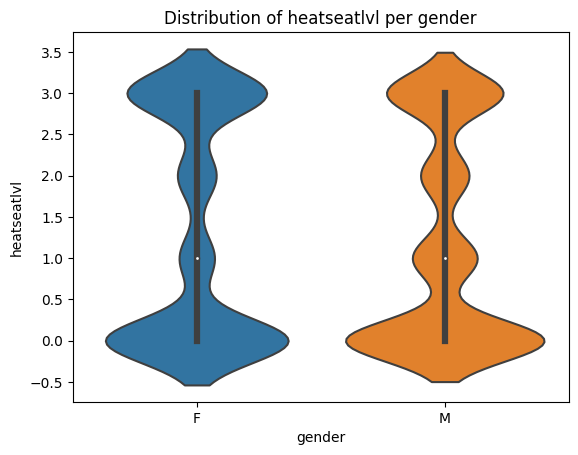

In [5]:
sns.violinplot(data=df, y=target, x="gender").set_title(
    "Distribution of " + target + " per gender"
)

In [6]:
df.keys()

Index(['timeTab', 'id', 'gender', 'weight', 'height', 'age',
       'experiment_number', 'timepoint', 'overallComfort',
       'autoFanModeEnbl_chg', 'vent_chg', 'fandist_chg',
       'heatedSteeringWheelButton_chg', 'heatseatlvl_chg', 'drvHCSMCool_chg',
       'accmEngRunReq_chg', 'setPointTemp_chg', 'Seat_Cushion_Surface',
       'Seat_Back_Surface', 'avgTC07toTC16Tmp', 'humdSensorRH', 'temperature',
       'relativeHumidity', 'ambSolLoadV', 'autoFanModeEnbl',
       'heatedSteeringWheelButton', 'heatseatlvl', 'drvHCSMCool',
       'setPointTemp', 'time_to_comfort'],
      dtype='object')

In [7]:
fig = px.scatter(
    df.groupby(by="experiment_number").agg("mean"),
    x="temperature",
    y=target,
    trendline="ols",
    title="Heated seat level vs outside temperature",
)
fig.update_layout(
    autosize=False, width=500, height=500, margin=dict(l=40, r=20, t=50, b=50)
)

fig.show()

C:\Users\larsr\AppData\Local\Temp\ipykernel_17868\4212619661.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by="experiment_number").agg("mean"),


In [8]:
fig = px.scatter(
    df.groupby(by="experiment_number").agg("mean"),
    x="weight",
    y=target,
    trendline="ols",
    title="Heated seat level vs weight",
)
fig.update_layout(
    autosize=False, width=500, height=500, margin=dict(l=40, r=20, t=50, b=50)
)

fig.show()

C:\Users\larsr\AppData\Local\Temp\ipykernel_17868\1707882580.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [9]:
fig = px.scatter(
    df.groupby(by="experiment_number").agg("mean"),
    x="height",
    y=target,
    trendline="ols",
    title="Heated seat level vs height",
)
fig.update_layout(
    autosize=False, width=500, height=500, margin=dict(l=40, r=20, t=50, b=50)
)

fig.show()

C:\Users\larsr\AppData\Local\Temp\ipykernel_17868\1374392673.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [10]:
fig = px.scatter(
    df[df["avgTC07toTC16Tmp"] > 5].groupby(by="experiment_number").agg("mean"),
    x="avgTC07toTC16Tmp",
    y=target,
    trendline="ols",
    title="Heated seat level vs inside temperature",
)
fig.update_layout(
    autosize=False, width=500, height=500, margin=dict(l=40, r=20, t=50, b=50)
)

fig.show()

C:\Users\larsr\AppData\Local\Temp\ipykernel_17868\3458030503.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



## Preprocessing

In [11]:
selection = [
    "avgTC07toTC16Tmp",
    "humdSensorRH",
    "temperature",
    "relativeHumidity",
    "ambSolLoadV",
    "id",
    "gender",
    "weight",
    "experiment_number",
    "timepoint",
    "age",
    "height",
]
target = "heatseatlvl"

df = df[selection + [target, "heatseatlvl_chg"]]
df = df.dropna()
df["male"] = df["gender"].apply(lambda x: 1 if x == "M" else 0)
df["female"] = df["gender"].apply(lambda x: 1 if x == "F" else 0)
sub_df = df.groupby("id").nunique()[target].reset_index()
change_setpoint = sub_df[sub_df[target] > 1]["id"].values
other = sub_df[sub_df[target] == 1]["id"].values

## Model training and validation

In [12]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier


class SMWrapper(BaseEstimator, ClassifierMixin):
    """A universal sklearn-style wrapper for statsmodels regressors"""

    def __init__(self, model_class):
        self.model_class = model_class

    def fit(self, X, y):

        if self.model_class == OrderedModel:
            self.model_ = self.model_class(y, X, distr="logit")
        else:
            self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit(method="bfgs", disp=False)
        return self

    def predict(self, X):
        prediction_prob = self.results_.model.predict(self.results_.params, exog=X)
        prediction = prediction_prob.argmax(1)
        return prediction


def init_log_reg_model(norm=True, model="logreg"):
    if model == "rf":
        model = RandomForestClassifier(
            random_state=0, min_samples_split=10, min_samples_leaf=10
        )  # , class_weight="balanced")
    else:
        model = LogisticRegression(
            random_state=0, solver="newton-cholesky", max_iter=500
        )  # , class_weight="balanced")

    if norm:
        pipe = make_pipeline(StandardScaler(), model)
    else:
        pipe = make_pipeline(model)
    return pipe


def init_ord_reg_model(norm=True):
    model = SMWrapper(OrderedModel)
    if norm:
        pipe = make_pipeline(StandardScaler(), model)
        return pipe
    else:
        return model

In [13]:
# (Optional) train a personal model for participants that change their setpoint, the coefficients could be used to scale the outside temp of the general model
def scale_features(df, feature="avgTC07toTC16Tmp", target="heatseatlvl", test_exp=[]):
    weights = {}
    for person in df["id"].unique():
        sub_df = df[(~df["experiment_number"].isin(test_exp)) & (df["id"] == person)]
        if len(sub_df) == 0:
            weights[person] = {feature: [[0]]}
            continue
        if len(sub_df[target].unique()) == 1:
            weights[person] = {feature: [[0]]}
            print(person, len(sub_df["target"].unique()) == 0)
            continue

        feature_df = sub_df[[feature]]
        target_df = sub_df[target]
        model = init_log_reg_model(norm=True)
        model.fit(feature_df, target_df)

        weights[person] = {
            # "Cabin Temp (C)":model.named_steps["smwrapper"].results_.params["x1"]
            feature: model.named_steps["logisticregression"].coef_
        }

    df[feature + "weight0"] = df["id"].apply(
        lambda x: weights[x][feature][0][0] if x in weights.keys() else 0
    )
    df[feature + "weight1"] = df["id"].apply(
        lambda x: weights[x][feature][1][0] if len(weights[x][feature]) >= 2 else 0
    )
    df[feature + "weight2"] = df["id"].apply(
        lambda x: weights[x][feature][2][0] if len(weights[x][feature]) >= 3 else 0
    )

    df["scaled_cabin_temp0"] = df[feature] * df[feature + "weight0"]
    df["scaled_cabin_temp1"] = df[feature] * df[feature + "weight1"]
    df["scaled_cabin_temp2"] = df[feature] * df[feature + "weight2"]
    return df

In [14]:
# A function to perform cross validation per experiment
def cross_validate(
    df, features, target, verbose=0, ordered=False, scaled_feature=False, rf=False
):
    accs = []
    correct_predictions = []
    test_predictions = []

    df = df.copy()
    for i, test_exp in enumerate(list(df["experiment_number"].unique())):
        if scaled_feature:
            df = scale_features(
                df,
                feature="avgTC07toTC16Tmp",
                target="heatseatlvl_chg",
                test_exp=[test_exp],
            )
            features.append("scaled_cabin_temp0")
            features.append("scaled_cabin_temp1")
            features.append("scaled_cabin_temp2")
        if ordered:
            model = init_ord_reg_model(norm=True)
        else:
            if rf:
                model = init_log_reg_model(norm=True, model="rf")
            else:
                model = init_log_reg_model(norm=True, model="logreg")

        test_set = True
        if test_set:
            model.fit(
                df[~df["experiment_number"].isin([test_exp])][features],
                df[~df["experiment_number"].isin([test_exp])][target],
            )
        else:
            model.fit(df[features], df[target])

        if test_set:
            test_target = df[df["experiment_number"].isin([test_exp])][target]
            test_prediction = model.predict(
                df[df["experiment_number"].isin([test_exp])][features]
            )
        else:
            test_target = df[target]
            test_prediction = model.predict(df[features])
        if verbose:
            print(
                "Accuracy score: ",
                accuracy_score(test_target, test_prediction),
                "Experiment no: ",
                test_exp,
            )
            print("Predictions: ", test_prediction)
            print("Target: ", test_target.values)
        accs.append(accuracy_score(test_target, test_prediction))
        correct_predictions += [
            1 if i == j else 0 for i, j in zip(test_target, test_prediction)
        ]
        test_predictions += [(i, j) for i, j in zip(test_target, test_prediction)]
    return correct_predictions, test_predictions, accs

In [ ]:
# personal model
features = ["avgTC07toTC16Tmp"]
correct_predictions = []
test_predictions = []
accs = []
for person in change_setpoint:
    sub_df = df[
        (df["id"] != "KCJ338") & (df["id"].isin(change_setpoint)) & (df["id"] == person)
    ]
    correct_prediction, test_prediction, acc = cross_validate(
        sub_df, features, target, verbose=0, ordered=False, scaled_feature=False
    )
    accs += acc
    correct_predictions += correct_prediction
    test_predictions += test_prediction
print(np.mean(correct_predictions), len(correct_predictions))
print("Percentage partially right: ", len([i for i in accs if i > 0.3]) / len(accs))

In [15]:
# general model
features = [
    "avgTC07toTC16Tmp",
    # "temperature",
]  # , "weight", "timepoint", "ambSolLoadV"]
correct_predictions, test_prediction, acc = cross_validate(
    df[(df["id"] != "KCJ338") & (df["id"].isin(change_setpoint))],
    features,
    target,
    verbose=0,
    ordered=False,
    scaled_feature=True,
    rf=False,
)
print("accuracy: ", np.mean(correct_predictions), len(correct_predictions))
print("Percentage partially right: ", len([i for i in acc if i > 0.3]) / len(acc))

accuracy:  0.6061574208539064 6886
Percentage partially right:  0.7945205479452054
